In [46]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import ExponentialDecay

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [47]:
AUTOTUNE = tf.data.AUTOTUNE #automatically adjust number of processes used for data
BATCH_SIZE = 25 * strategy.num_replicas_in_sync #each processor will simultaneously process same batch size
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]


In [48]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [49]:
#count the number of normal vs not patients
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [50]:
def get_label(file_path):
    #convert path into a list of path componenets
    parts = tf.strings.split(file_path, "/")
    #2nd to last is class directory
    if parts [-2] == "PNEUMONIA":
        return 1
    else:
        return 0

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label

ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [51]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [52]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [53]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [54]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [55]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [56]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

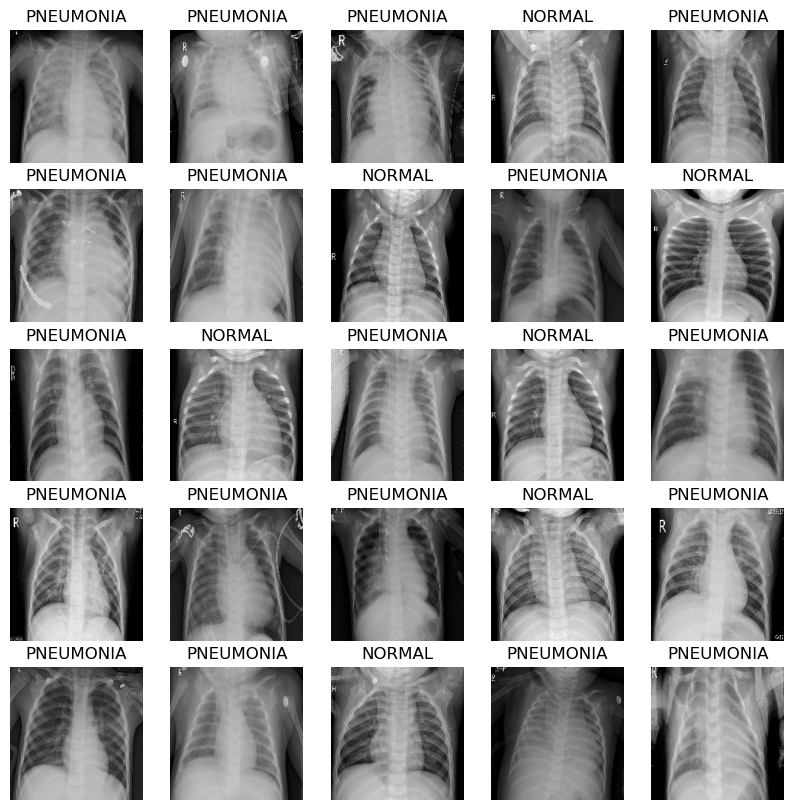

In [57]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [58]:
import os 
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras import layers

#extract features, uses relu activate function, padding set to same
def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs

#full connected layer
def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs) #uses relu to introduce non-linearity
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [59]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs) #normalise the pixel values for images range between 0 and 1
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x) #convolutional layer
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x) #another convolutional layer
    x = layers.MaxPool2D()(x) #pooling layer, get important feature

    x = conv_block(32, x)
    x = conv_block(64, x)

    #regularisation, prevent overfitting
    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    #flatten and dense layers
    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x) #512 units, 70% dropout rate
    x = dense_block(128, 0.5, x) 
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x) #uses sigmoid activation function to output a single probability between 0 and 1

    model = keras.Model(inputs=inputs, outputs=outputs) #construct the keras model
    return model

In [60]:
#adds a bias to get rid of the imbalanced data, there are a lot more phneumonia patients than healthy ones
#make it so the normal images are weighted more to balance the data
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [62]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

#initial_learning_rate = 0.015
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
 #   initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
#)

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        #optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
    142/Unknown - 145s 532ms/step - loss: 0.4149 - binary_accuracy: 0.7921 - precision: 0.9528 - recall: 0.7597

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

model.evaluate(test_ds, return_dict=True)